In [1]:
%%capture
import sys

# Añade el directorio principal al path de búsqueda para importar módulos desde esa ubicación
sys.path.insert(0, "..")

# Desactivar los warnings para evitar mensajes innecesarios durante la ejecución
import warnings

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

from likelihood.models.deep import (
    AutoClassifier,
    setup_model,
    GetInsights,
)  # Modelos de deep learning personalizados
from likelihood.tools import OneHotEncoder, get_metrics  # Herramientas auxiliares

warnings.filterwarnings("ignore")
import tensorflow as tf

import matplotlib.pyplot as plt

is_updated = False
from packaging import version

if version.parse(tf.__version__) > version.parse("2.15.0"):
    is_updated = True

plt.rcParams["font.size"] = 10
plt.style.use("seaborn-v0_8")

E0000 00:00:1754983066.644941   71955 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754983066.649235   71955 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754983066.661792   71955 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754983066.661807   71955 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754983066.661809   71955 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754983066.661811   71955 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# Cargar el dataset de cáncer de mama desde sklearn
df = datasets.load_breast_cancer()

# Convertir los datos a un DataFrame de pandas para facilitar la manipulación
df_cancer = pd.DataFrame(data=df.data, columns=df.feature_names)
df_cancer["target"] = df.target  # Añadir la columna de etiquetas 'target'

# OneHotEncoder convierte las etiquetas a formato one-hot encoding
y_encoder = OneHotEncoder()
y = y_encoder.encode(df_cancer["target"].to_list())  # Codificar las etiquetas de la clase (target)
X = df_cancer.drop(
    columns="target"
).to_numpy()  # Extraer las características (sin la columna 'target')
X = np.asarray(X).astype(np.float32)  # Convertir X a tipo float32 para la entrada del modelo
y = np.asarray(y).astype(np.float32)  # Convertir y a tipo float32

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Crear el modelo de clasificación automática con las especificaciones dadas
model = AutoClassifier(
    input_shape_parm=X.shape[1],  # El número de características de entrada (columnas de X)
    num_classes=y.shape[1],  # El número de clases (salidas) del modelo
    units=17,  # Número de unidades en las capas ocultas
    activation="selu",  # Función de activación de las capas ocultas
    l2_reg=0.0,
)

# Compilación del modelo: optimizador, función de pérdida y métricas
model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)

# Entrenar el modelo con los datos, usando 15 épocas y 20% de los datos para validación
model.fit(X_train, y_train, epochs=15, validation_split=0.2, verbose=False)

# Hacer predicciones sobre el conjunto de entrenamiento
pred = model.predict(X)

# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df = df_cancer.copy()
y_labels = df.drop(columns="target").columns.to_list()
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1

# Calcular y mostrar las métricas del modelo comparando las etiquetas reales y las predicciones
get_metrics(df_cancer, "target", "prediction", verbose=True)

# Guardar el DataFrame con las predicciones en un archivo CSV
df_cancer.to_csv("test.csv", index=False)

# Guardar el modelo entrenado en el disco en formato TensorFlow
if is_updated:
    model.save("best_model")
else:
    model.save("best_model", save_format="tf")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 92.44%
Precision: 91.10%
Recall: 97.48%
F1-Score: 94.18
Cohen's Kappa: 0.8344


In [4]:
# Cargar el modelo guardado desde el disco
if is_updated:
    model = AutoClassifier.load("best_model")
else:
    model = tf.keras.models.load_model("best_model")
model.summary()
# Hacer predicciones nuevamente con el modelo cargado
pred = model.predict(X)

# Obtener las etiquetas predichas para las nuevas predicciones
pred_label = np.argmax(pred, axis=1)

# Añadir las nuevas predicciones al DataFrame original
df["prediction"] = pred_label

# Calcular y mostrar las métricas nuevamente con el modelo cargado
get_metrics(df, "target", "prediction", verbose=True)

=== AutoClassifier Summary ===

--- Encoder ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 17)             │           527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 8)              │           144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 671 (2.62 KB)

 Trainable params: 671 (2.62 KB)

 Non-trainable params: 0 (0.00 B)


--- Decoder ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 17)             │           153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 30)             │           540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693 (2.71 KB)

 Trainable params: 693 (2.71 KB)

 Non-trainable params: 0 (0.00 B)


--- Classifier ---


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ classifier_input (InputLayer)   │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 2)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78 (312.00 B)

 Trainable params: 78 (312.00 B)

 Non-trainable params: 0 (0.00 B)


--- Main Model ---


Model: "auto_classifier_main"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 8)         │        671 │ main_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 30)        │        693 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combine_features    │ (None, 38)        │          0 │ decoder[0][0],    │
│ (Concatenate)       │                   │            │ encoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier          │ (None, 2)         │         78 │ combine_features… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,328 (16.91 KB)

 Trainable params: 1,442 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,886 (11.28 KB)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 92.44%
Precision: 91.10%
Recall: 97.48%
F1-Score: 94.18
Cohen's Kappa: 0.8344


In [5]:
# Fine-tuning del modelo con más épocas de entrenamiento
model.freeze_encoder_decoder()  # Congelar las capas de encoder y decoder
model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)
model.fit(X_train, y_train, epochs=15, validation_split=0.2, verbose=False)
model.summary()

if is_updated:
    model.save("fine_tuned_model")
else:
    model.save("fine_tuned_model", save_format="tf")
print("Modelo fine-tuned guardado en disco.")

if is_updated:
    model = AutoClassifier.load("fine_tuned_model")
else:
    model = tf.keras.models.load_model("fine_tuned_model")
print("Modelo fine-tuned cargado desde disco.")

# Hacer predicciones nuevamente con el modelo fine-tuned
pred = model.predict(X)

# Obtener las etiquetas predichas para las nuevas predicciones
pred_label = np.argmax(pred, axis=1)

# Añadir las nuevas predicciones al DataFrame original
df["prediction"] = pred_label

# Calcular y mostrar las métricas nuevamente con el modelo fine-tuned
get_metrics(df, "target", "prediction", verbose=True)

=== AutoClassifier Summary ===

--- Encoder ---


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 17)             │           527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 8)              │           144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 671 (2.62 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 671 (2.62 KB)


--- Decoder ---


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 17)             │           153 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 30)             │           540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693 (2.71 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 693 (2.71 KB)


--- Classifier ---


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ classifier_input (InputLayer)   │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 2)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78 (312.00 B)

 Trainable params: 78 (312.00 B)

 Non-trainable params: 0 (0.00 B)


--- Main Model ---


Model: "auto_classifier_main"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 8)         │        671 │ main_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 30)        │        693 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combine_features    │ (None, 38)        │          0 │ decoder[0][0],    │
│ (Concatenate)       │                   │            │ encoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier          │ (None, 2)         │         78 │ combine_features… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,600 (6.25 KB)

 Trainable params: 78 (312.00 B)

 Non-trainable params: 1,364 (5.33 KB)

 Optimizer params: 158 (636.00 B)

Modelo fine-tuned guardado en disco.
Modelo fine-tuned cargado desde disco.
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 92.79%
Precision: 92.70%
Recall: 96.08%
F1-Score: 94.36
Cohen's Kappa: 0.8439


In [6]:
model, best_hps = setup_model(
    data=df_cancer.drop(columns=["prediction", "label_0", "label_1"]),
    target="target",
    epochs=10,
    filepath="./best_model",
    verbose=False,
    method="RandomSearch",
    hyperparameters={
        "activation": "tanh",
        "units": [8, 16],
        "optimizer": "adam",
    },
)

In [7]:
best_hps

,units,threshold,num_layers,dropout,l2_reg,vae_mode
Value,8,0.457601,9,0.153252,0.000002,0


In [8]:
pred = model.predict(X)
# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1
get_metrics(df_cancer, "target", "prediction", verbose=True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 87.52%
Precision: 86.86%
Recall: 94.40%
F1-Score: 90.47
Cohen's Kappa: 0.7249


In [9]:
if is_updated:
    model = AutoClassifier.load("best_model")
else:
    model = tf.keras.models.load_model("best_model")

pred = model.predict(X)
# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1
get_metrics(df_cancer, "target", "prediction", verbose=True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 92.44%
Precision: 91.10%
Recall: 97.48%
F1-Score: 94.18
Cohen's Kappa: 0.8344


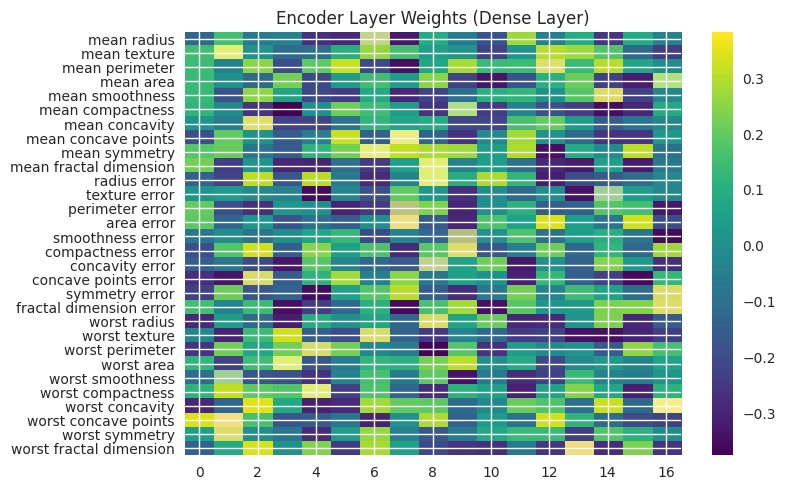

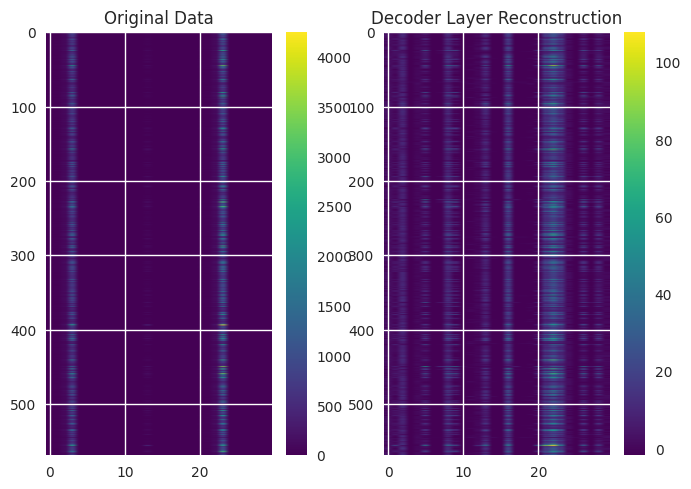

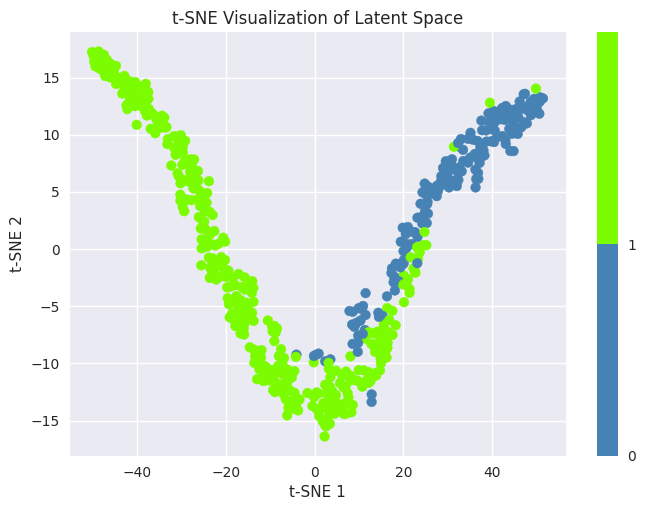

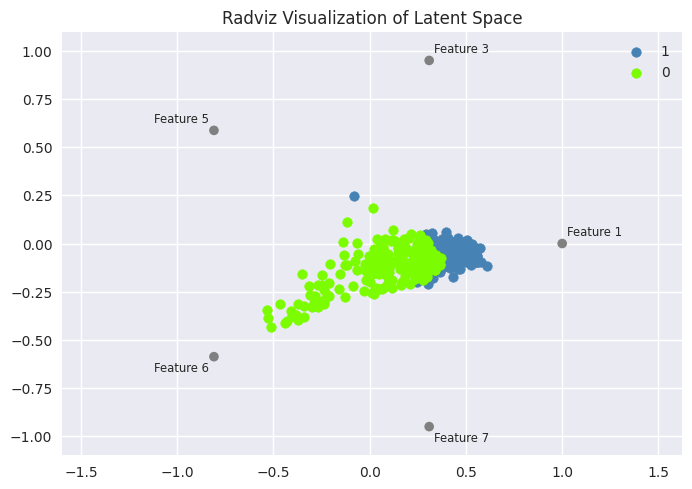

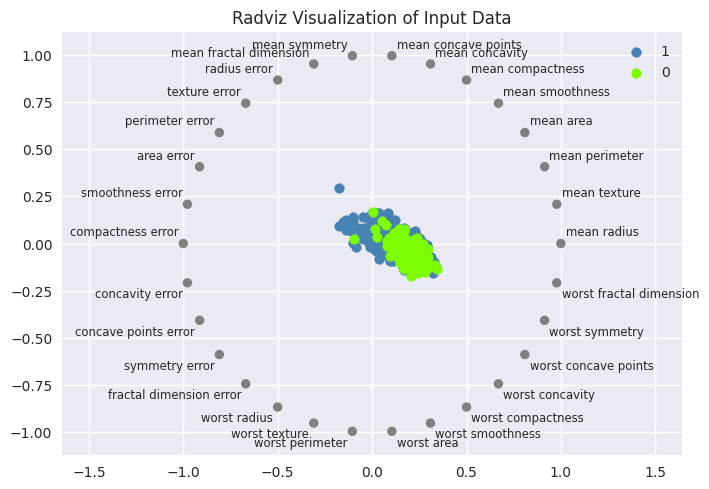

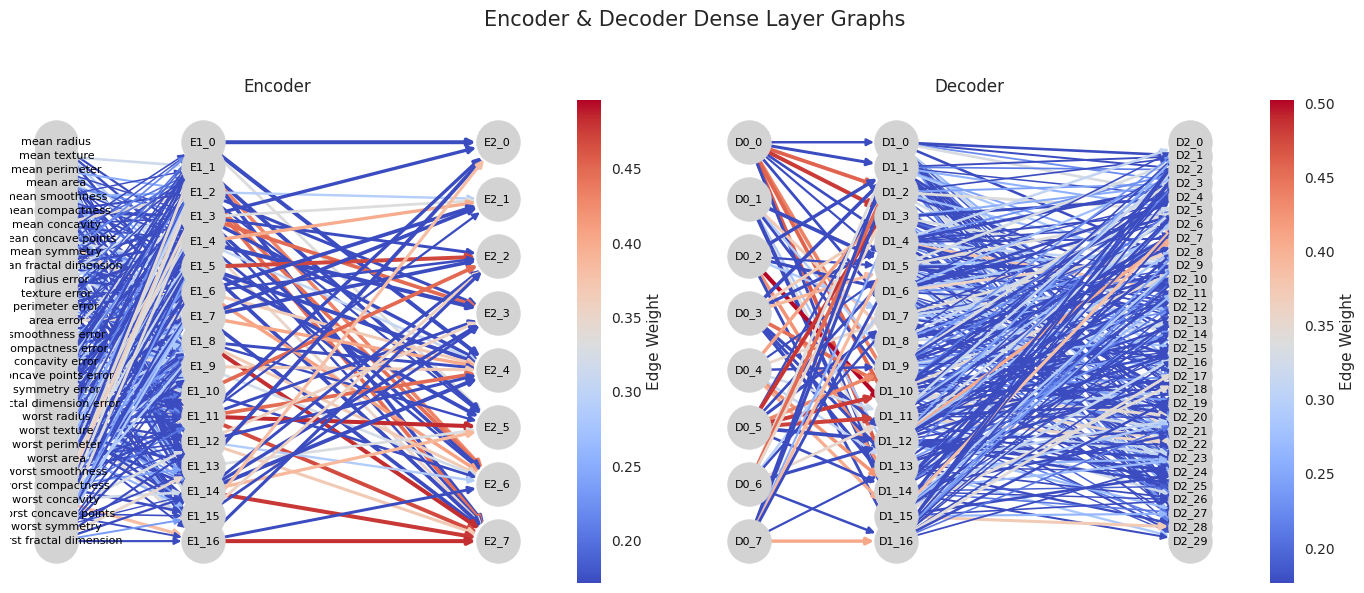

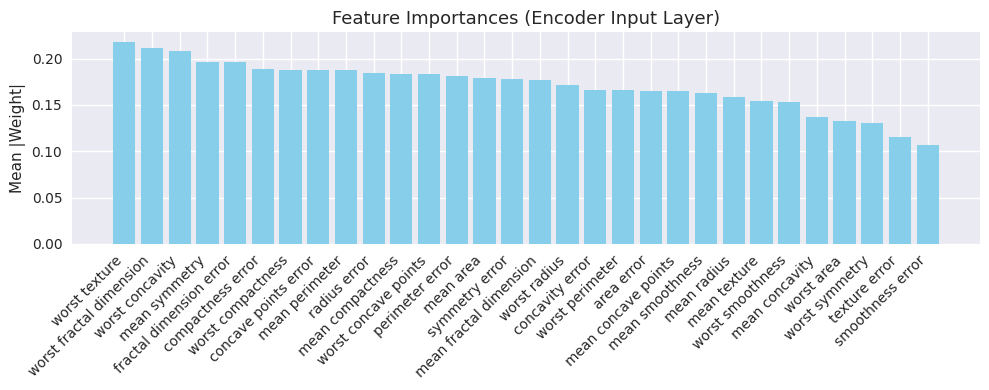

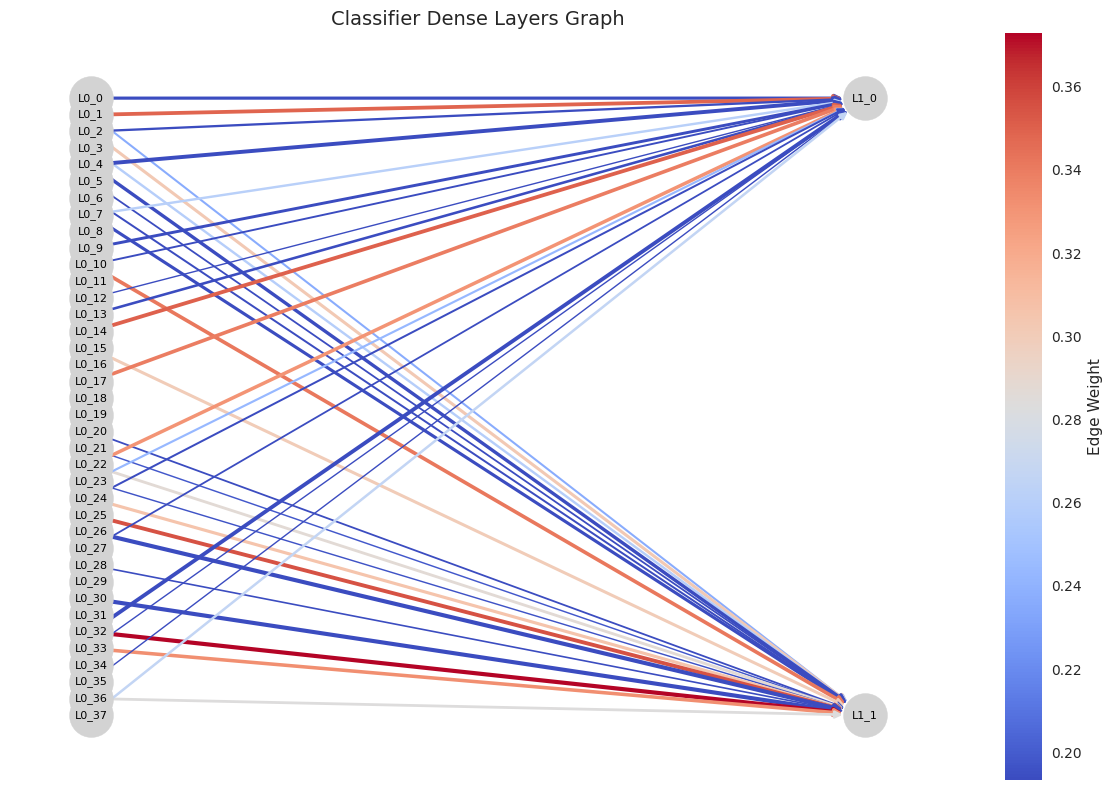

class,0,1
mean radius_mean,17.757380,12.350259
mean radius_min,11.840000,6.981000
mean radius_max,27.420000,28.110001
mean radius_std,3.041332,2.089221
mean radius_median,17.910000,12.270000


In [10]:
insights = GetInsights(model, X)
insights.render_html_report(frac=1.0, top_k=5, y_labels=y_labels)